In [1]:
import numpy as np
import networkx as nx
import matplotlib
from scipy.stats import multivariate_normal
%matplotlib inline

## Let us try out networkx on an example tree

We will use this tree for all the incoming computations. Especially, the tree is defined by the following variables
\begin{align}
(x_1, x_2, x_3, x_4, y_1, y_2, z_1) = (v_0, v_1, v_2, v_3, v_4, v_5, v_6)
\end{align}
$x$ designates the leaves (observed or last layer of hidden variables). These variables will be connected later to an observation model. $y$ and $z$ denotes the first order and second order of internal nodes. $v_6 = z_1$ is the root node (associated to the prior of the Gaussian random walk).

In [2]:
# let us encode the adjacency matrix 
# A_{ij} = 0 if no edge between i and j
# A_{ij} > 0 means there is an edge and denotes the duration from the parent to the child
# A_{ij} < 0 is not allowed
A = np.array([[0, 0, 0, 0, 1, 0, 0], 
              [0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1, 0],
              [1, 1, 0, 0, 0, 0, 1],
              [0, 0, 1, 1, 0, 0, 1],
              [0, 0, 0, 0, 1, 1, 0]])

T = nx.from_numpy_array(A)

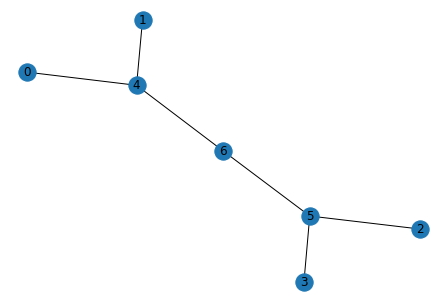

In [3]:
nx.draw(T, with_labels=True)

In order to collect the prior information while computing the posterior predictive density, we need to add a virtual node with the prior information as follow

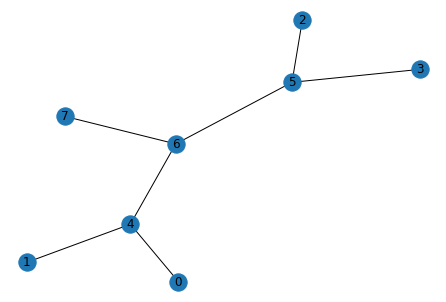

In [4]:
# add a fake node to simulate the prior
T_add = nx.Graph(T)
T_add.add_node(7)
T_add.add_edge(6, 7, weight=1)
nx.draw(T_add, with_labels=True)

## 1. Exact computations via matrix inversion

For this, we need to compute the mean and covariance of the marginals. The mean will always be zero. We are therefore left with computing the covariances. For this, let us start by forming the precision matrix of the whole distribution

\begin{align}
\log p(x1, y1, x2, z1, x3, y2, x4) = \sum_{nodes} \log p(node \mid parent) \\
 = \sum_{nodes} - \frac{|| x - \pi(x)||^2}{2 \delta_{x, \pi(x)}^2} \\
  = \sum_{nodes} -\frac{1}{2} \left[ \frac{x^2}{\delta_{x, \pi(x)}^2} + \frac{\pi(x)^2}{\delta_{x, \pi(x)}^2} - 2\frac{x\pi(x)}{\delta_{x, \pi(x)}^2} \right] \\
  = \sum_{ij} -\frac{1}{2} \Sigma^{-1}_{ij} x_i x_j
\end{align}

From this we can identify the coefficients in linear time

(z1) = (x7)

(y1, y2) = (x5, x6)

(x1, x2, x3, x4)

In [5]:
parents = {1:5, 2:5, 3:6, 4:6, 5:7, 6:7}

In [6]:
d = 2
inverse_covariance = np.zeros((7 * d, 7 * d))
for i in range(6):
    pi_ind = parents[i + 1] - 1
    inverse_covariance[i * d: (i + 1) * d, i * d: (i + 1) * d] += np.identity(d)
    inverse_covariance[pi_ind * d: (pi_ind + 1) * d, pi_ind * d: (pi_ind + 1) * d] += np.identity(d)
    inverse_covariance[pi_ind * d: (pi_ind + 1) * d, i * d: (i + 1) * d] += - np.identity(d)
    inverse_covariance[i * d: (i + 1) * d, pi_ind * d: (pi_ind + 1) * d] += - np.identity(d)
inverse_covariance[4 * d: (4 + 1) * d, 4 * d: (4 + 1) * d] += np.identity(d)

full_covariance = np.linalg.inv(inverse_covariance)

In [7]:
print("Inverse covariance")
print(inverse_covariance)
print("Full covariance")
print(full_covariance)

inverse_covariance.shape, full_covariance.shape

Inverse covariance
[[ 1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0.]
 [-1.  0. -1.  0.  0.  0.  0.  0.  4.  0.  0.  0. -1.  0.]
 [ 0. -1.  0. -1.  0.  0.  0.  0.  0.  4.  0.  0.  0. -1.]
 [ 0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  3.  0. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  3.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  2.]]
Full covariance
[[2. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 2. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 2. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0

((14, 14), (14, 14))

## 2. Exact computations via message passing

Initialize the network with messages

In [8]:
def initialize_messages(G, d, evidence, prior_node):
    dic_nu = {}
    dic_mu = {}
    dic_log_z = {}
    for i, x in enumerate(evidence):
        dic_nu[i] = 0
        dic_log_z[i] = 0
        dic_mu[i] = x
    dic_nu[prior_node] = 0
    dic_mu[prior_node] = np.zeros(d)
    dic_log_z[prior_node] = 0
    nx.set_node_attributes(G, dic_nu, 'nu')
    nx.set_node_attributes(G, dic_mu, 'mu')
    nx.set_node_attributes(G, dic_log_z, 'log_z')

In [9]:
def initialize_visit(G, prior_node):
    dic_visited = {}
    for node in G:
        dic_visited[node] = False
    nx.set_node_attributes(G, dic_visited, 'visited')

In [10]:
def perform_message_passing_2(T, root_node, prior_node, include_prior):
    # print(root_node)
    # flag the node as visited
    T.nodes[root_node]["visited"] = True
            
    incoming_messages = []
    # get list of neighbors that are not visited yet
    for node in T.neighbors(root_node):
        if not T.nodes[node]["visited"] and (node != prior_node  or (node == prior_node and include_prior) ):
            perform_message_passing(T, node, prior_node, include_prior)
            incoming_messages.append(node)
            
    # collect and return 
    if len(incoming_messages) == 0:
        # nothing to do. This happens on the leaves
        return None
    
    elif len(incoming_messages) == 1:
        # this happens when passing through the root
        k = incoming_messages[0]
        T.nodes[root_node]["nu"] = T.nodes[k]["nu"] + T[root_node][k]["weight"]
        T.nodes[root_node]["mu"] = T.nodes[k]["mu"]
        T.nodes[root_node]["log_z"] = 0
            
    elif len(incoming_messages) == 2:
        # let us give them arbitrary names k and l (could be left and right)
        k = incoming_messages[0]
        l = incoming_messages[1]
        
        # let us compute the updates
        k_nu_inc = T.nodes[k]["nu"] + T[root_node][k]["weight"]
        l_nu_inc = T.nodes[l]["nu"] + T[root_node][l]["weight"]
        
        T.nodes[root_node]["nu"] = 1. / ( 1. / k_nu_inc + 1. / l_nu_inc)
        T.nodes[root_node]["mu"] = T.nodes[k]["mu"] / k_nu_inc + T.nodes[l]["mu"] / l_nu_inc
        T.nodes[root_node]["mu"] *= T.nodes[root_node]["nu"]
        
        lambda_ = k_nu_inc + l_nu_inc
        T.nodes[root_node]["log_z"] = -0.5 * np.sum((T.nodes[k]["mu"] - T.nodes[l]["mu"]) ** 2) / lambda_
        T.nodes[root_node]["log_z"] -= d * 0.5 * np.log(2 * np.pi * lambda_)         

    elif len(incoming_messages) == 3:
        # This happens when performing the posterior predictive variant of the message passing
         # let us give them arbitrary names k, l and m 
        k = incoming_messages[0]
        l = incoming_messages[1]       
        m = incoming_messages[2]
        
        # let us compute the updates
        k_nu_inc = T.nodes[k]["nu"] + T[root_node][k]["weight"]
        l_nu_inc = T.nodes[l]["nu"] + T[root_node][l]["weight"]
        m_nu_inc = T.nodes[m]["nu"] + T[root_node][m]["weight"]
        
        T.nodes[root_node]["nu"] = 1. / ( 1. / k_nu_inc + 1. / l_nu_inc + 1. / m_nu_inc)
        T.nodes[root_node]["mu"] = T.nodes[k]["mu"] / k_nu_inc + T.nodes[l]["mu"] / l_nu_inc + T.nodes[m]["mu"] / m_nu_inc
        T.nodes[root_node]["mu"] *= T.nodes[root_node]["nu"]
        
        lambda_ = k_nu_inc * l_nu_inc + k_nu_inc * m_nu_inc + l_nu_inc * m_nu_inc
        T.nodes[root_node]["log_z"] = m_nu_inc * np.sum((T.nodes[k]["mu"] - T.nodes[l]["mu"]) ** 2)
        T.nodes[root_node]["log_z"] += l_nu_inc * np.sum((T.nodes[k]["mu"] - T.nodes[m]["mu"]) ** 2) 
        T.nodes[root_node]["log_z"] += k_nu_inc * np.sum((T.nodes[l]["mu"] - T.nodes[m]["mu"]) ** 2) 
        T.nodes[root_node]["log_z"] *= -0.5 / lambda_
        T.nodes[root_node]["log_z"] -= d * 0.5 * np.log(2 * np.pi * lambda_)
        
    else:
        # Here there is a problem, we might have tried to compute something wierd
        raise NotImplementedError("This should not happen (more than 3). Node" + str(root_node))

In [11]:
def product_without(L, exclude):
    """
    L: list of elements
    exclude: list of the elements indices to exlucde
    
    returns: product of all desired array elements
    """
    prod = 1
    for idx, x in enumerate(L):
        if idx in exclude:
            continue
        else:
            prod *= x
    return prod   

def perform_message_passing(T, root_node, prior_node, include_prior):
    # print(root_node)
    # flag the node as visited
    T.nodes[root_node]["visited"] = True
            
    incoming_messages = []
    # get list of neighbors that are not visited yet
    for node in T.neighbors(root_node):
        if not T.nodes[node]["visited"] and (node != prior_node  or (node == prior_node and include_prior) ):
            perform_message_passing(T, node, prior_node, include_prior)
            incoming_messages.append(node)
            
    # collect and return 
    if len(incoming_messages) == 0:
        # nothing to do. This happens on the leaves
        return None
    
    elif len(incoming_messages) == 1:
        # this happens when passing through the root
        k = incoming_messages[0]
        T.nodes[root_node]["nu"] = T.nodes[k]["nu"] + T[root_node][k]["weight"]
        T.nodes[root_node]["mu"] = T.nodes[k]["mu"]
        T.nodes[root_node]["log_z"] = 0   
        
    elif len(incoming_messages) >= 2:
        # children node i = incoming_messages[i]
        # n: number of children
        n = len(incoming_messages)

        #we will keep track of mean and variances of the children nodes in 2 lists
        children_nu = [0]*n
        children_mu = [0]*n

        #updates: mean and variance

        #lambda: used later for the normalizing constant
        for i in range(n):
            k = incoming_messages[i]
            children_nu[i] = T.nodes[k]["nu"] + T[root_node][k]["weight"]
            T.nodes[root_node]["nu"] += 1. / children_nu[i]
            children_mu[i] = T.nodes[k]["mu"] / children_nu[i]
            T.nodes[root_node]["mu"] += children_mu[i]


        T.nodes[root_node]["nu"] = 1. / T.nodes[root_node]["nu"]
        T.nodes[root_node]["mu"] *= T.nodes[root_node]["nu"]

        #find t
        t = 0
        for excluded_idx in range(n):
            prod = product_without(children_nu, [excluded_idx])
            t += prod

        #normalizing constant
        Z_1 = -0.5 * (n - 1) * d * np.log(2 * np.pi)
        Z_2 = -0.5 * d * np.log(t)
        Z_3 = 0

        #nested for loop
        for j in range(n):
            for h in range(n):
                if h == j:
                    continue
                else:
                    prod_2 = product_without(children_nu, [j, h])
            k = incoming_messages[h]
            l = incoming_messages[j]
            Z_3 += prod_2 * np.sum((T.nodes[k]["mu"] - T.nodes[l]["mu"]) ** 2)
        Z_3 *= -0.5 / t

        T.nodes[root_node]["log_z"] = Z_1 + Z_2 + Z_3

In [12]:
def aggregate_messages_into_leaves_likelihood(T, root, add_prior):
    res = 0
    
    # agg Z messages
    for node in T.nodes():
        res += T.nodes[node]["log_z"]
        
    if add_prior:
        # add prior
        nu_inc = 1 + T.nodes[root]["nu"]
        res += - 0.5 * np.sum(T.nodes[root]["mu"] ** 2) / nu_inc - d * 0.5 * np.log(2 * np.pi * nu_inc)
    
    return res

### 2.a case for leaves marginals (for VI bound)

the task here is to compute $\log p(x_1, x_2, x_3, x_4)$. This can be done quickly via marginalization of the Gaussian vector

In [16]:
evidence = [np.array([1.0] * d), np.array([1.0] * d), np.array([1.0] * d), np.array([1.0] * d)]

# marginalization of covariance
leaves_covariance = full_covariance[:4 * d, :4 * d]
leaves_mean = np.array([0] * 4 * d)

# message passing: call from the root
root = 6
prior_node = 7
tree = T_add
collect_prior_node = False

initialize_visit(tree, prior_node)
initialize_messages(tree, d, evidence + [0] * 1 * d, prior_node)
perform_message_passing_2(tree, root, prior_node, collect_prior_node)

print("Gaussian marginalization output O(n^3d^3): ",
      multivariate_normal.logpdf(np.hstack(evidence), leaves_mean, leaves_covariance))

print("Message passing output O(nd): ", 
      aggregate_messages_into_leaves_likelihood(tree, root, add_prior=True)) 

Gaussian marginalization output O(n^3d^3):  -10.890603962634772
Message passing output O(nd):  -10.967459274789377


### 2.b case for posterior predictive density

First, let us try to compute the probability of a leave $n$ given observation at all the others, for example
$$x_4 \mid x_1, x_2, x_3$$
For this, we need simply need to maginalize $x_4, y_1, y_2, z_1 \mid x_1, x_2, x_3$, itself given by the Gaussian condioning formula

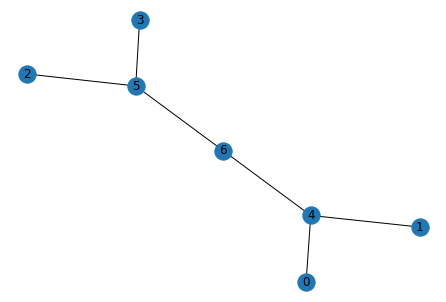

In [38]:
nx.draw(T, with_labels=True)

In [53]:
leaves_covariance.shape, full_covariance.shape, cov_ii.shape

((8, 8), (14, 14), (6, 6))

In [40]:
#calculate the mean and variance of x_4 | x_1, x_2, x_3
evidence = [np.array([1] * d), np.array([2] * d), np.array([1] * d)]

# Gaussian conditioning formula
cov_ii = full_covariance[3 * d:, 3 * d:]
cov_il = full_covariance[3 * d:, :3 * d]
cov_ll = full_covariance[:3 * d, :3 * d]
cov_li = full_covariance[:3 * d, 3 * d:]

internal_post_mean_transform = np.dot(cov_il, np.linalg.inv(cov_ll))
internal_post_covar = cov_ii - np.dot(np.dot(cov_il, np.linalg.inv(cov_ll)), cov_li)

# message passing: call from the leaf and collect the prior information
query_node = 3
prior_node = 7
tree = T_add
collect_prior_node = True

# perform message passing
initialize_visit(tree, prior_node)
initialize_messages(tree, d, evidence + [0] * 4 * d, prior_node)
perform_message_passing(tree, query_node, prior_node, collect_prior_node)

print("Gaussian conditioning formula O(n^3d^3): ",
      np.dot(internal_post_mean_transform, np.hstack(evidence))[0: d], internal_post_covar[0, 0])

print("Message passing output O(nd): ", 
      tree.nodes[query_node]["mu"], tree.nodes[query_node]["nu"])

Gaussian conditioning formula O(n^3d^3):  [1. 1.] 1.7000000000000002
Message passing output O(nd):  [0.84615385 0.84615385] 1.6153846153846154


In [50]:
cov_ii.shape, cov_il.shape, cov_ll.shape, cov_li.shape, full_covariance.shape

((6, 6), (6, 8), (8, 8), (8, 6), (14, 14))

In [46]:
internal_post_mean_transform.shape, np.hstack(evidence).shape

((8, 6), (6,))

Second, let us try to compute the probability of an internal nodes $n$ given observation at all the leaves, for example
$$y_1 \mid x_1, x_2, x_3, x_4$$
For this, we need simply need to maginalize $y_1, y_2, z_1 \mid x_1, x_2, x_3, x_4$, itself given by the Gaussian conditioning formula

In [49]:
#calculate the mean and variance of y_1 | x_1, x_2, x_3
evidence = [np.array([1] * d), np.array([2] * d), np.array([1] * d), np.array([1] * d)]

# Gaussian conditioning formula
cov_ii = full_covariance[4 * d:, 4 * d:]
cov_il = full_covariance[4 * d:, :4 * d]
cov_ll = full_covariance[:4 * d, :4 * d]
cov_li = full_covariance[:4 * d, 4 * d:]

internal_post_mean_transform = np.dot(cov_il, np.linalg.inv(cov_ll))
internal_post_covar = cov_ii - np.dot(np.dot(cov_il, np.linalg.inv(cov_ll)), cov_li)

# message passing: call from the leaf and collect the prior information
query_node = 4
prior_node = 7
tree = T_add
collect_prior_node = True

# perform message passing
initialize_visit(tree, prior_node)
initialize_messages(tree, d, evidence + [0] * 3 * d, prior_node)
perform_message_passing(tree, query_node, prior_node, collect_prior_node)

print("Gaussian conditioning formula O(n^3d^3): ",
      np.dot(internal_post_mean_transform, np.hstack(evidence))[0: d], internal_post_covar[0, 0])

print("Message passing output O(nd): ", 
      tree.nodes[query_node]["mu"], tree.nodes[query_node]["nu"])

Gaussian conditioning formula O(n^3d^3):  [1. 1.] 0.2941176470588236
Message passing output O(nd):  [1.23809524 1.23809524] 0.38095238095238093
